<a href="https://colab.research.google.com/github/dina-masry/House-Price-Prediction/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Import required packages

In [ ]:
!pip install keras_tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , OrdinalEncoder , OneHotEncoder ,MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import HyperParameters as hp
import keras_tuner as kt
from tf_keras.optimizers import Adam , Nadam, RMSprop
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns', 100)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

##Custom function

In [ ]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes

##Load Data

In [ ]:
path= '/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Week19/Data/train.csv'
df= pd.read_csv(path)
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


##Inspect Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

- This data consists of 80 features and 1640 entries.
- There are float64(3), int64(35), object(43) datatypes of features.
- There are null values.

In [ ]:
# check duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# delete id feature
df.drop('Id', axis=1, inplace=True)

In [ ]:
# show features with too many null values
df.isnull().sum()[df.isnull().sum()>1000]

,0
Alley,1369
PoolQC,1453
Fence,1179
MiscFeature,1406


In [ ]:
# delete features with too many null values
df.drop(['Alley','PoolQC','Fence','MiscFeature'], axis=1, inplace=True)

##Preprocessing

In [ ]:
# split the data into 3 groups : train , validation , testing
y= df['SalePrice']
X= df.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# preprocess numeric features
num_cols = X_train.select_dtypes(include='number').columns
imputer= SimpleImputer(strategy='median')
scaler= StandardScaler()
num_transformer = make_pipeline(imputer, scaler)
num_tuple = ('numeric', num_transformer, num_cols)

In [ ]:
# preprocess ordinal features
ord_cols =['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond',
           'LandSlope','BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'GarageFinish', 'PavedDrive']
categories = [
    # For ExterQual, ExterCond, HeatingQC, KitchenQual, GarageQual, GarageCond
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['Po', 'Fa', 'TA', 'Gd', 'Ex'],

    # For BsmtQual, BsmtCond, FireplaceQu
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],
    ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex'],

    # For LandSlope
    ['Sev', 'Mod', 'Gtl'],

    # For BsmtExposure
    ['NA', 'No', 'Mn', 'Av', 'Gd'],

    # For BsmtFinType1, BsmtFinType2
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],


    # For GarageFinish
    ['NA', 'Unf', 'RFn', 'Fin'],

    # For PavedDrive
    ['N', 'P', 'Y']
]
imputer = SimpleImputer(strategy='most_frequent')
ord_encoder = OrdinalEncoder(categories= categories, handle_unknown='use_encoded_value', unknown_value=-1)
ord_transformer = make_pipeline(imputer, ord_encoder)
ord_tuple = ('ordinal', ord_transformer, ord_cols)

In [ ]:
# preprocess for categorical features
ord_cols_object = [col for col in ord_cols if col in X_train.select_dtypes(include='object').columns]
cat_cols = X_train.select_dtypes(include='object').drop(columns= ord_cols_object).columns
imputer= SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(sparse_output=False , drop= 'first',handle_unknown='ignore')
cat_transformer = make_pipeline(imputer, cat_encoder)
cat_tuple = ('categorical', cat_transformer, cat_cols)

In [ ]:
# column transformer
preprocessor = ColumnTransformer(transformers=[num_tuple, ord_tuple, cat_tuple],verbose_feature_names_out=False)
# fit on trainig set
preprocessor.fit(X_train)
# transform train and validation sets
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert processed arrays back to DataFrames with correct column names
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_val_processed = pd.DataFrame(X_val_processed, columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [ ]:
X_train_processed.shape

(1022, 194)

##Inspect the target

In [ ]:
y_train.describe()

,SalePrice
count,1022.000000
mean,181312.692759
std,77617.461005
min,34900.000000
25%,130000.000000
50%,165000.000000
75%,215000.000000
max,745000.000000


## First Model : Baseline model --> At the end : it was the best model.

In [ ]:
input_shape = X_train_processed.shape[1]
input_shape

194

In [ ]:
model = Sequential()

In [ ]:
model.add(Dense(194, activation='relu', input_shape=(input_shape,)))
model.add(Dense(128, activation='relu'))

In [ ]:
model.add(Dense(1, activation='linear'))

In [ ]:
model.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history = model.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 186527.5312 - mean_absolute_error: 186527.5312 - root_mean_squared_error: 203937.8906 - val_loss: 174251.8594 - val_mean_absolute_error: 174251.8594 - val_root_mean_squared_error: 194867.7031
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 186403.2969 - mean_absolute_error: 186403.2969 - root_mean_squared_error: 203822.6250 - val_loss: 173807.1562 - val_mean_absolute_error: 173807.1562 - val_root_mean_squared_error: 194459.1406
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 185741.5469 - mean_absolute_error: 185741.5469 - root_mean_squared_error: 203206.6406 - val_loss: 172287.6406 - val_mean_absolute_error: 172287.6406 - val_root_mean_squared_error: 193060.3281
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 183763.0312 - mean_absolute_error: 183763.0312 - root_mean_squared_error: 201361.2656 - val_loss: 168727.8594 - val_mean_absolute_error: 168727.8594 - val_root_mean_squared_error: 189789.

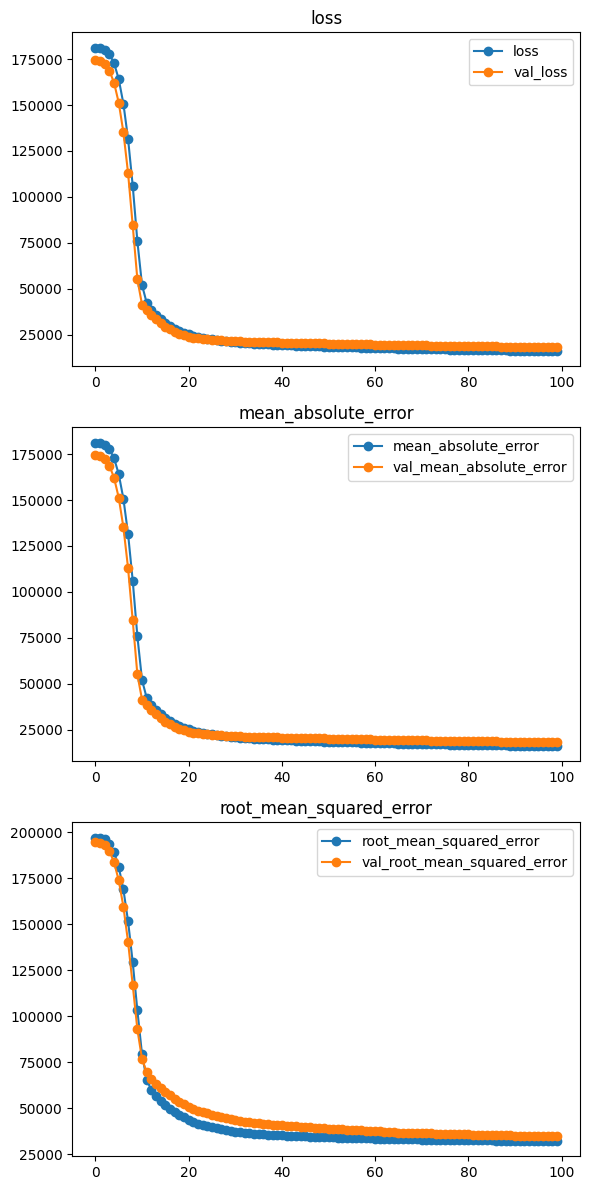

In [ ]:
plot_history(history);

In [ ]:
# evaluate on training set
y_pred = model.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
final RMSE: 32118.74069760519
final MAE: 15988.9150390625
final R2: 0.8285950422286987


In [ ]:
# evaluate on testing set
y_pred = model.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
final RMSE: 23051.41731000504
final MAE: 15982.2421875
final R2: 0.9154011011123657


##Second Model :

In [ ]:
input_shape = X_train_processed.shape[1]
input_shape

194

In [ ]:
# add more neurons and layers
model_2 = Sequential()
model_2.add(Dense(194, activation='relu', input_shape=(input_shape,)))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dense(1, activation='linear'))

In [ ]:
model_2.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history_2 = model_2.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 186523.2188 - mean_absolute_error: 186523.2188 - root_mean_squared_error: 203933.9844 - val_loss: 174004.9688 - val_mean_absolute_error: 174004.9688 - val_root_mean_squared_error: 194639.9062
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 184067.0625 - mean_absolute_error: 184067.0625 - root_mean_squared_error: 201707.6250 - val_loss: 139019.6562 - val_mean_absolute_error: 139019.6562 - val_root_mean_squared_error: 163025.7500
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 104989.2266 - mean_absolute_error: 104989.2266 - root_mean_squared_error: 132138.2031 - val_loss: 42144.4023 - val_mean_absolute_error: 42144.4023 - val_root_mean_squared_error: 78049.1641
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 42404.4688 - mean_absolute_error: 42404.4688 - root_mean_squared_error: 67788.8672 - val_loss: 25448.8789 - val_mean_absolute_error: 25448.8789 - val_root_mean_squared_error: 52180.3789
Epoc

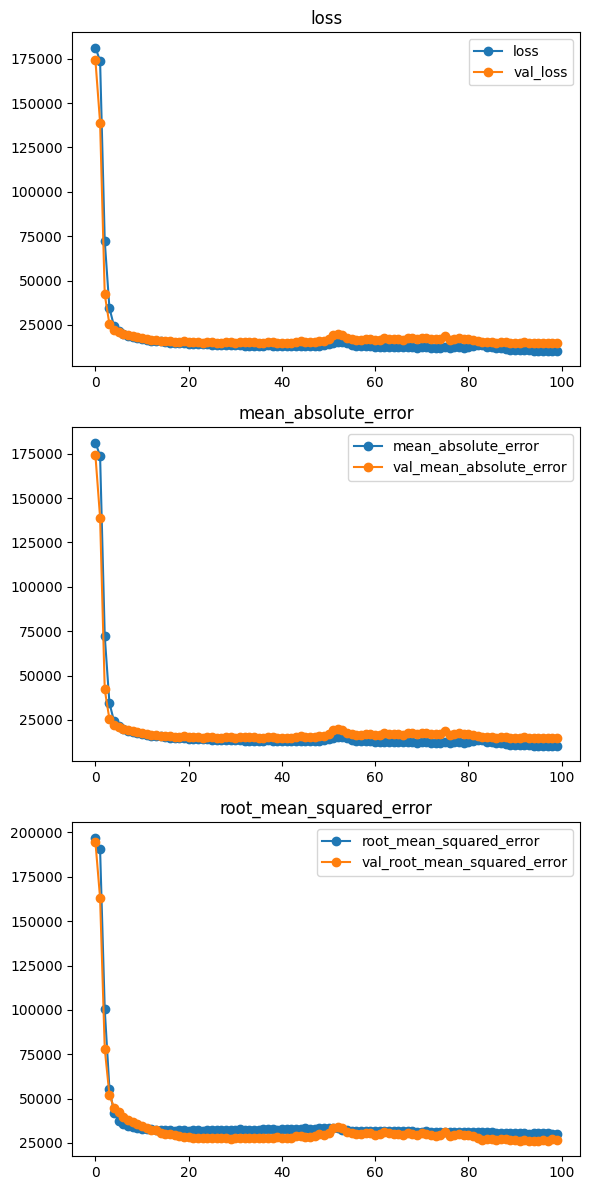

In [ ]:
plot_history(history_2);

In [ ]:
# evaluate model on training set
y_pred = model_2.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
final RMSE: 29962.10086092095
final MAE: 10317.20703125
final R2: 0.8508405089378357


In [ ]:
# evaluate on testing set (unseen data)
y_pred = model_2.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
final RMSE: 21037.559554282907
final MAE: 14682.9912109375
final R2: 0.9295371770858765


- Model 2 is overfitting , try to use dropout.

In [ ]:
model_3 = Sequential()
model_3.add(Dense(194, activation='relu', input_shape=(input_shape,)))
model_3.add(Dropout(0.001))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.001))
model_3.add(Dense(1,activation='linear'))

In [ ]:
model_3.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history_3 = model_3.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 186524.2969 - mean_absolute_error: 186524.2969 - root_mean_squared_error: 203934.8906 - val_loss: 174219.2656 - val_mean_absolute_error: 174219.2656 - val_root_mean_squared_error: 194837.5000
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 186335.0469 - mean_absolute_error: 186335.0469 - root_mean_squared_error: 203758.5312 - val_loss: 173555.2188 - val_mean_absolute_error: 173555.2188 - val_root_mean_squared_error: 194224.7812
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 185351.8438 - mean_absolute_error: 185351.8438 - root_mean_squared_error: 202840.6562 - val_loss: 171332.7969 - val_mean_absolute_error: 171332.7969 - val_root_mean_squared_error: 192176.5625
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 182474.6406 - mean_absolute_error: 182474.6406 - root_mean_squared_error: 200155.7969 - val_loss: 166231.7656 - val_mean_absolute_error: 166231.7656 - val_root_mean_squared_error: 187491.

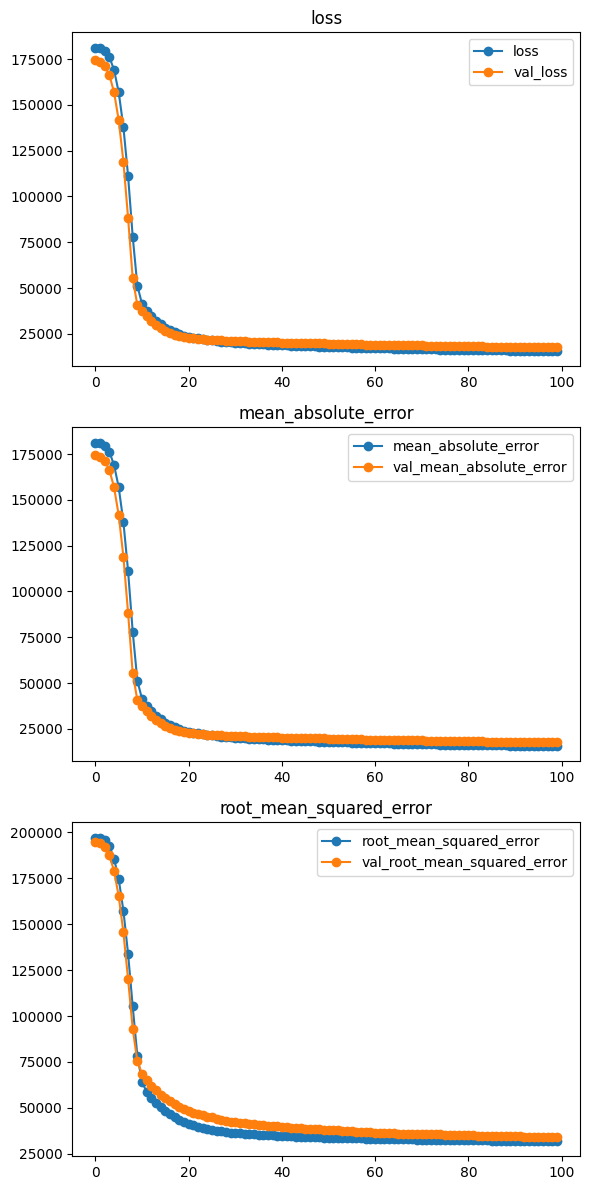

In [ ]:
plot_history(history_3);

In [ ]:
# evaluate on training set
y_pred = model_3.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
final RMSE: 31858.698027383354
final MAE: 15555.8828125
final R2: 0.831359326839447


In [ ]:
# evaluate on testing set
y_pred = model_3.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
final RMSE: 22667.951649851384
final MAE: 15665.6416015625
final R2: 0.9181923866271973


- There is no overfitting , The gap between results in training and testing sets is very small.

### Use scaled target

In [ ]:
# scaled the target
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_val_scaled = scaler.transform(y_val.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

In [ ]:
# using scaled target
history= model_2.fit(X_train_processed, y_train_scaled, validation_data=(X_val_processed, y_val_scaled), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 130114.7266 - mean_absolute_error: 130114.7266 - root_mean_squared_error: 149333.9844 - val_loss: 18054.0293 - val_mean_absolute_error: 18054.0293 - val_root_mean_squared_error: 21473.0078
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 14163.4189 - mean_absolute_error: 14163.4189 - root_mean_squared_error: 17790.3418 - val_loss: 1014.5417 - val_mean_absolute_error: 1014.5417 - val_root_mean_squared_error: 1955.7013
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 364.5180 - mean_absolute_error: 364.5180 - root_mean_squared_error: 1466.1855 - val_loss: 1.4242 - val_mean_absolute_error: 1.4242 - val_root_mean_squared_error: 1.6832
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3216 - mean_absolute_error: 1.3216 - root_mean_squared_error: 1.9498 - val_loss: 0.7134 - val_mean_absolute_error: 0.7134 - val_root_mean_squared_error: 0.8128
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0

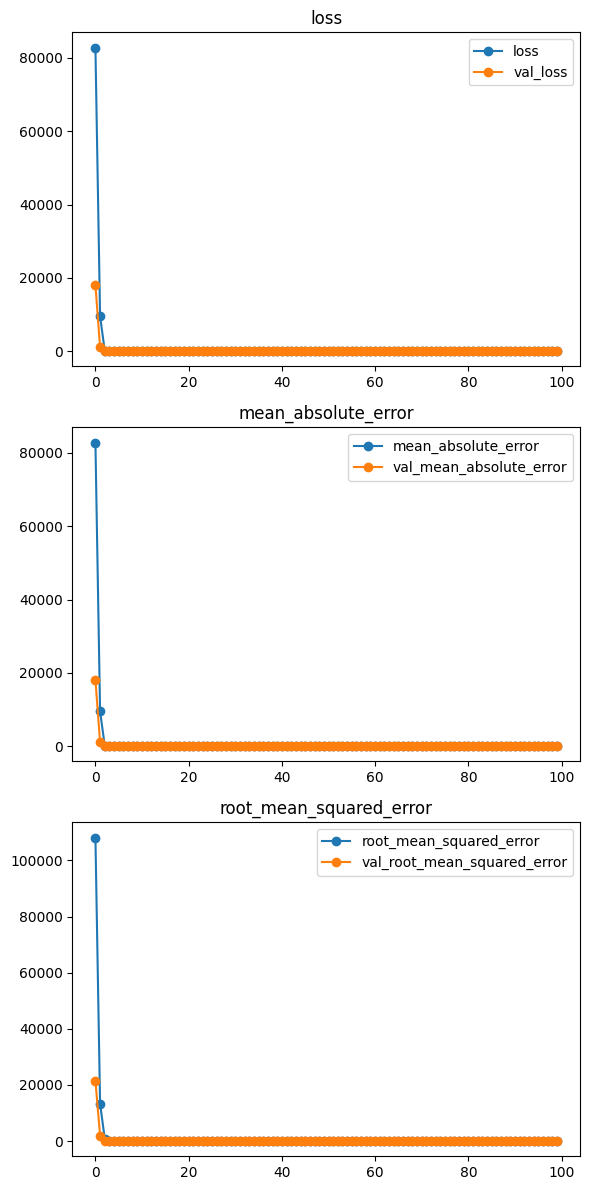

In [ ]:
plot_history(history);

In [ ]:
y_train_pred = model_2.predict(X_train_processed)
y_train_pred = scaler.inverse_transform(y_train_pred)
# evaluate
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_train_pred)}')
print(f'final R2: {r2_score(y_train, y_train_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
final RMSE: 54931.84023860843
final MAE: 26939.79296875
final R2: 0.49863433837890625


In [ ]:
# make predictions
y_pred_scaled = model_2.predict(X_test_processed)
y_pred = scaler.inverse_transform(y_pred_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# evaluate
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

final RMSE: 34000.3350571726
final MAE: 26219.02734375
final R2: 0.8159500360488892


- The loss is very big !

## Use dropout for model_2

In [ ]:
model_2 = Sequential()
model_2.add(Dense(194, activation='relu', input_shape=(input_shape,)))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.1))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dense(64, activation='relu'))
model_2.add(Dropout(0.01))
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(32, activation='relu'))
model_2.add(Dropout(0.001))
model_2.add(Dense(1, activation='linear'))

In [ ]:
model_2.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history_2 = model_2.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 186514.2344 - mean_absolute_error: 186514.2344 - root_mean_squared_error: 203925.8125 - val_loss: 173745.3125 - val_mean_absolute_error: 173745.3125 - val_root_mean_squared_error: 194401.5938
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 181827.8438 - mean_absolute_error: 181827.8438 - root_mean_squared_error: 199749.0938 - val_loss: 105450.8516 - val_mean_absolute_error: 105450.8516 - val_root_mean_squared_error: 134338.2031
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 75286.8984 - mean_absolute_error: 75286.8984 - root_mean_squared_error: 102101.7266 - val_loss: 33464.8047 - val_mean_absolute_error: 33464.8047 - val_root_mean_squared_error: 65424.3242
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 35442.2344 - mean_absolute_error: 35442.2344 - root_mean_squared_error: 58228.3438 - val_loss: 23275.8027 - val_mean_absolute_error: 23275.8027 - val_root_mean_squared_error: 48988.7227
Epoch 

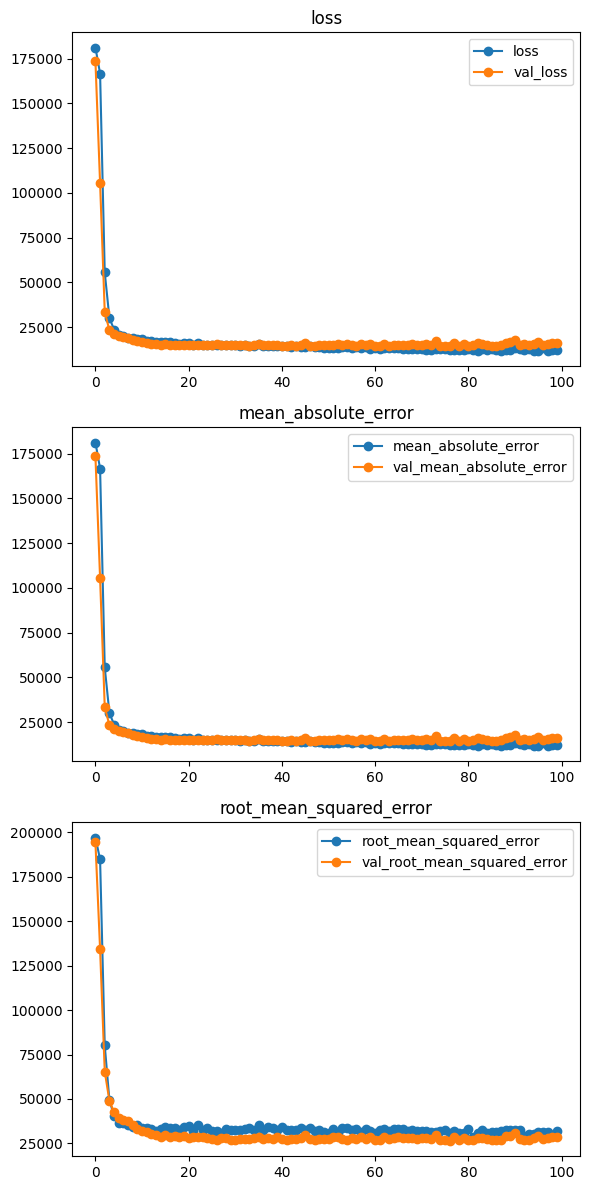

In [ ]:
plot_history(history_2);

In [ ]:
# evaluate on training set
y_pred = model_2.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
final RMSE: 28531.120412630135
final MAE: 10447.171875
final R2: 0.864747941493988


In [ ]:
# evaluate on testing set
y_pred = model_2.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
final RMSE: 20431.212984059464
final MAE: 14104.21484375
final R2: 0.933540403842926


- It`s a little bit underfitting

## Third model

In [ ]:
# Build and Compile Model within a function to try different optimizers, units,learning rates and dropout values
def build_model(hp):
    # Instantiate Model
    model = Sequential()
    # hidden layers
    # Try different values for units
    model.add(Dense(units=hp.Int('units', min_value=100, max_value=194, step=10),input_dim = input_shape, activation='relu'))
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=100, max_value=128, step=20), activation='relu'))
    model.add(Dense(units=hp.Int('units', min_value=34, max_value=64, step=10), activation='relu'))
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=hp.Int('units', min_value=10, max_value=34, step=10), activation='relu'))
    model.add(Dense(1, activation = 'linear'))

    # Try different optimizers and learning rates by passing their string names
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
    learning_rate = hp.Choice('learning_rate', values=[.01, .001, .0001])
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile Model with the chosen optimizer and learning rate
    model.compile(optimizer=optimizer,
                  loss='mae', # Use mse for regression task
                 metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
    return model

In [ ]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [ ]:
# Define tuner object
tuner = kt.Hyperband(build_model, objective='val_mean_absolute_error', max_epochs=100, directory=folder, overwrite = True, seed = 42 , project_name='Houses_prices_tuning')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
# Run the tuner
tuner.search(X_train_processed, y_train,  epochs=100, validation_data= (X_val_processed , y_val), callbacks = [early_stopping])

Trial 254 Complete [00h 00m 23s]
val_mean_absolute_error: 15324.9580078125

Best val_mean_absolute_error So Far: 14126.0126953125
Total elapsed time: 00h 57m 33s


In [ ]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 150)            │        29,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 150)            │        22,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,351 (380.28 KB)

 Trainable params: 97,351 (380.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_3 = best_model.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1,callbacks=[early_stopping])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 22624.2129 - mean_absolute_error: 22624.2129 - root_mean_squared_error: 45946.5078 - val_loss: 17971.2324 - val_mean_absolute_error: 17971.2324 - val_root_mean_squared_error: 29416.8027
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 11183.5947 - mean_absolute_error: 11183.5947 - root_mean_squared_error: 21517.1270 - val_loss: 15475.3926 - val_mean_absolute_error: 15475.3926 - val_root_mean_squared_error: 25425.5332
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12841.6885 - mean_absolute_error: 12841.6885 - root_mean_squared_error: 38460.9219 - val_loss: 14191.9131 - val_mean_absolute_error: 14191.9131 - val_root_mean_squared_error: 24446.6406
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 12236.2344 - mean_absolute_error: 12236.2344 - root_mean_squared_error: 38440.4102 - val_loss: 16102.9922 - val_mean_absolute_error: 16102.9922 - val_root_mean_squared_error: 27826.3945
Epoch 5/100
32/32 ━

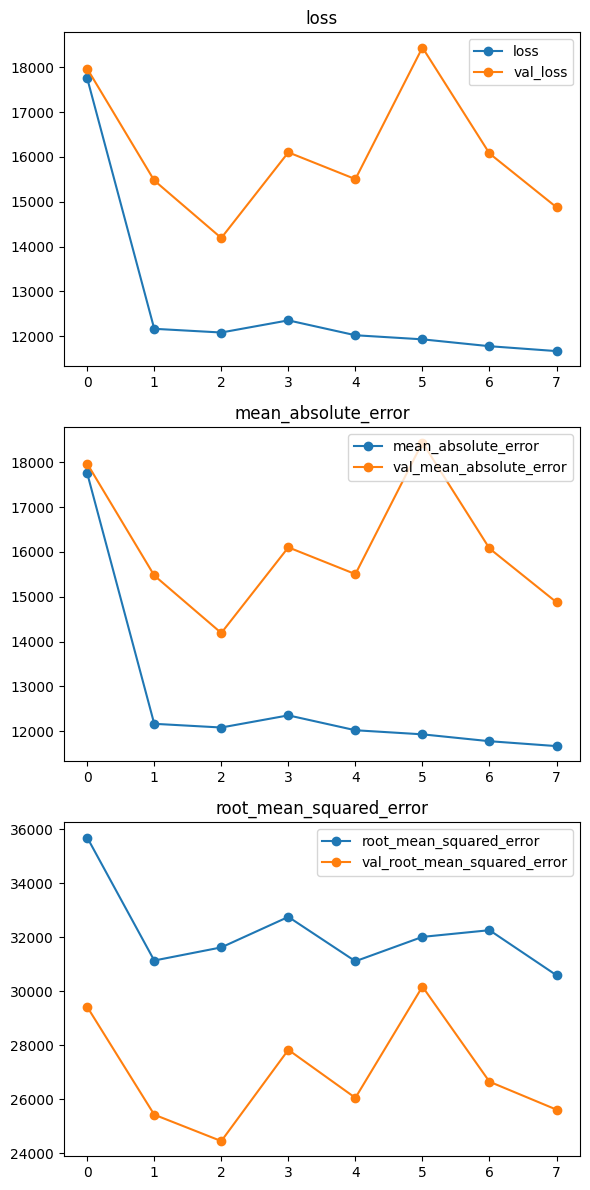

In [ ]:
plot_history(history_3);

In [ ]:
# evaluate on training set
y_pred = best_model.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
final RMSE: 29448.22385136326
final MAE: 10281.1474609375
final R2: 0.8559131026268005


In [ ]:
# evaluate on validation set
y_pred = best_model.predict(X_val_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_val, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_val, y_pred)}')
print(f'final R2: {r2_score(y_val, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
final RMSE: 25611.312500533822
final MAE: 14877.1416015625
final R2: 0.9138091802597046


In [ ]:
# evaluate on testing set (unseen data)
y_pred = best_model.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
final RMSE: 20430.98274679904
final MAE: 14272.6826171875
final R2: 0.9335418939590454


- It`s Overfitting!

In [ ]:
# fit using scaled target
history_4 = best_model.fit(X_train_processed, y_train_scaled, validation_data=(X_val_processed, y_val_scaled), epochs=100, batch_size=32, verbose=1,callbacks=[early_stopping])

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 64283.7734 - mean_absolute_error: 64283.7734 - root_mean_squared_error: 90732.4766 - val_loss: 0.2448 - val_mean_absolute_error: 0.2448 - val_root_mean_squared_error: 1.3678
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4457 - mean_absolute_error: 0.4457 - root_mean_squared_error: 4.9076 - val_loss: 0.0538 - val_mean_absolute_error: 0.0538 - val_root_mean_squared_error: 0.1732
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1693 - mean_absolute_error: 0.1693 - root_mean_squared_error: 1.3537 - val_loss: 0.0397 - val_mean_absolute_error: 0.0397 - val_root_mean_squared_error: 0.0676
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0523 - mean_absolute_error: 0.0523 - root_mean_squared_error: 0.2598 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317 - val_root_mean_squared_error: 0.0464
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403 - mean_absolute_error: 0.0403 - roo

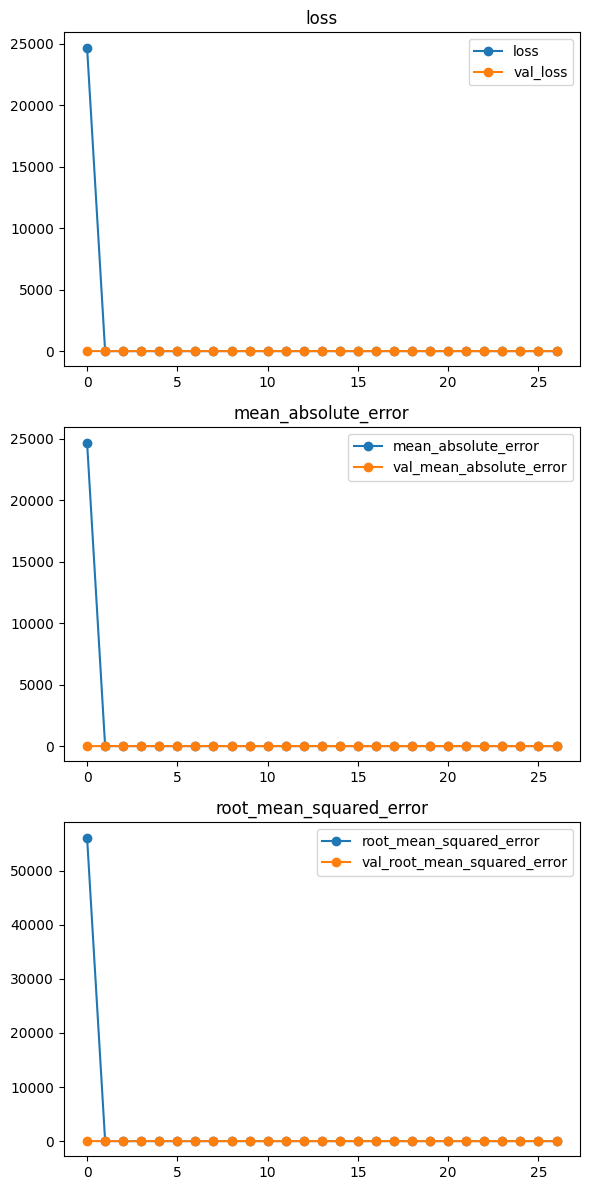

In [ ]:
plot_history(history_4);

In [ ]:
# make predictions
y_pred_scaled = best_model.predict(X_test_processed)
y_pred = scaler.inverse_transform(y_pred_scaled)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [ ]:
# evaluate
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

final RMSE: 23174.18149579398
final MAE: 15647.28515625
final R2: 0.9144976139068604


# Create another version of data:

In [ ]:
#create a new feature by combining all the porch and deck features into a single variable
df['TotalOutdoorSF'] = df['WoodDeckSF'] + df['OpenPorchSF'] + df['EnclosedPorch'] + df['3SsnPorch'] + df['ScreenPorch']
# delete the summed features
df.drop(['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch','3SsnPorch', 'ScreenPorch'], axis=1, inplace=True)

In [ ]:
# create a new feature by summing the total bathroom counts
df['TotalBaths'] = df['FullBath'] + (df['HalfBath']*0.5) + df['BsmtFullBath'] + (df['BsmtHalfBath']*0.5)
# delete the summed features
df.drop(['FullBath', 'HalfBath','BsmtFullBath', 'BsmtHalfBath'], axis=1, inplace=True)

In [ ]:
# create a new feature by summing the total square footage
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']+ df['GrLivArea']
# delete the summed features
df.drop(['TotalBsmtSF', '1stFlrSF', '2ndFlrSF','GrLivArea'], axis=1, inplace=True)

In [ ]:
# split the data
y= df['SalePrice']
X= df.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# preprocessing
# preprocess numeric features
num_cols = X_train.select_dtypes(include='number').columns
imputer= SimpleImputer(strategy='median')
scaler= StandardScaler()
num_transformer = make_pipeline(imputer, scaler)
num_tuple = ('numeric', num_transformer, num_cols)

In [ ]:
# preprocess for categorical features
ord_cols_object = [col for col in ord_cols if col in X_train.select_dtypes(include='object').columns]
cat_cols = X_train.select_dtypes(include='object').drop(columns= ord_cols_object).columns
imputer= SimpleImputer(strategy='most_frequent')
cat_encoder = OneHotEncoder(sparse_output=False , drop= 'first',handle_unknown='ignore')
cat_transformer = make_pipeline(imputer, cat_encoder)
cat_tuple = ('categorical', cat_transformer, cat_cols)

In [ ]:
# column transformer
preprocessor = ColumnTransformer(transformers=[num_tuple, ord_tuple, cat_tuple],verbose_feature_names_out=False)
# fit on trainig set
preprocessor.fit(X_train)
# transform train and validation sets
X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# Convert processed arrays back to DataFrames with correct column names
X_train_processed = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_val_processed = pd.DataFrame(X_val_processed, columns=preprocessor.get_feature_names_out())
X_test_processed = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())

In [ ]:
X_train_processed.shape

(1022, 184)

##First Model: Baseline model

In [ ]:
input_shape = X_train_processed.shape[1]
input_shape

184

In [ ]:
model_1 = Sequential()

In [ ]:
model_1.add(Dense(184, activation='relu', input_shape=(input_shape,)))
model_1.add(Dense(150, activation='relu'))
model_1.add(Dense(1, activation='linear'))

In [ ]:
model_1.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history_1 = model_1.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 186521.6250 - mean_absolute_error: 186521.6250 - root_mean_squared_error: 203932.3281 - val_loss: 174210.8281 - val_mean_absolute_error: 174210.8281 - val_root_mean_squared_error: 194829.2188
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 186324.5000 - mean_absolute_error: 186324.5000 - root_mean_squared_error: 203748.0781 - val_loss: 173538.8281 - val_mean_absolute_error: 173538.8281 - val_root_mean_squared_error: 194207.6250
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 185334.1875 - mean_absolute_error: 185334.1875 - root_mean_squared_error: 202822.2969 - val_loss: 171318.1719 - val_mean_absolute_error: 171318.1719 - val_root_mean_squared_error: 192158.8281
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 182458.5938 - mean_absolute_error: 182458.5938 - root_mean_squared_error: 200136.5781 - val_loss: 166206.4219 - val_mean_absolute_error: 166206.4219 - val_root_mean_squared_error: 187461.

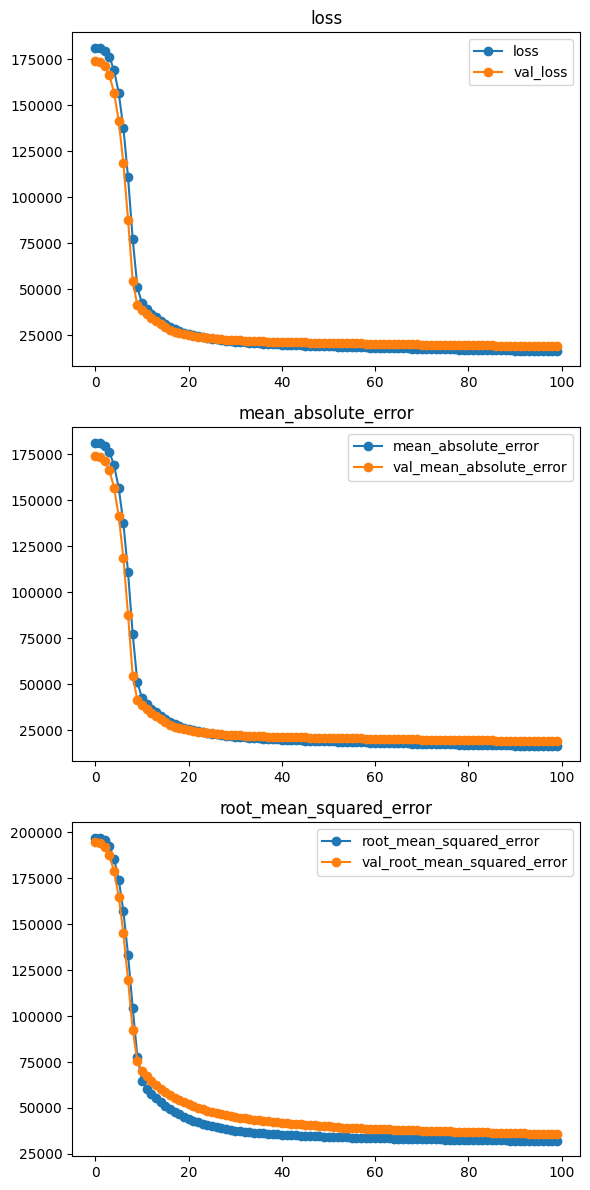

In [ ]:
plot_history(history_1);

- It is a little overfitting . It works better on training set



##Model 2 :

In [ ]:
model_2 = Sequential()

In [ ]:
model_2.add(Dense(184, activation='relu', input_shape=(input_shape,)))
model_2.add(Dense(170, activation='relu'))
model_2.add(Dense(130, activation='relu'))
model_2.add(Dense(80, activation='relu'))
model_2.add(Dense(40, activation='relu'))
model_2.add(Dense(30, activation='relu'))
model_2.add(Dense(20, activation='relu'))
model_2.add(Dense(1, activation='linear'))

In [ ]:
model_2.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
model_2.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 179032.1719 - mean_absolute_error: 179032.1719 - root_mean_squared_error: 194185.7656 - val_loss: 172875.4844 - val_mean_absolute_error: 172875.4844 - val_root_mean_squared_error: 193601.4531
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 165905.6094 - mean_absolute_error: 165905.6094 - root_mean_squared_error: 182963.1406 - val_loss: 69322.3281 - val_mean_absolute_error: 69322.3281 - val_root_mean_squared_error: 86714.1953
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 57579.7422 - mean_absolute_error: 57579.7422 - root_mean_squared_error: 76072.8047 - val_loss: 32631.2109 - val_mean_absolute_error: 32631.2109 - val_root_mean_squared_error: 63493.4102
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 33493.1992 - mean_absolute_error: 33493.1992 - root_mean_squared_error: 56648.6562 - val_loss: 24496.5684 - val_mean_absolute_error: 24496.5684 - val_root_mean_squared_error: 47976.3633
Epoch 5/50
32/

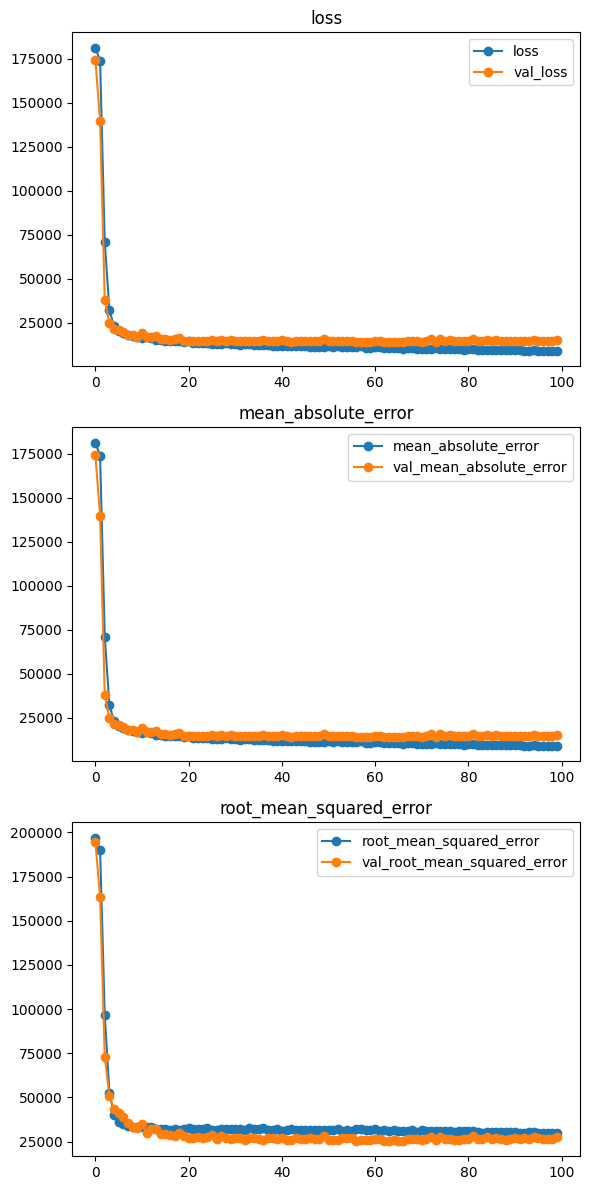

In [ ]:
plot_history(history_2);

In [ ]:
#evaluate on training set
y_pred = model_2.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
final RMSE: 30063.441186930017
final MAE: 11581.3046875
final R2: 0.8498297929763794


In [ ]:
# evaluate on testing set
y_pred = model_2.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
final RMSE: 20503.20170119779
final MAE: 14883.552734375
final R2: 0.9330712556838989


- A little overfitting

##Model 3:

## try to reduce overfitting using dropout

In [ ]:
def build_model(hp):
 model_3 = Sequential()
 model_3.add(Dense(184, activation='relu', input_shape=(input_shape,)))
 model_3.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.3, step=0.01)))
 model_3.add(Dense(170, activation='relu'))
 model_3.add(Dense(130, activation='relu'))
 model_3.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.3, step=0.01)))
 model_3.add(Dense(80, activation='relu'))
 model_3.add(Dense(40, activation='relu'))
 model_3.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.3, step=0.01)))
 model_3.add(Dense(30, activation='relu'))
 model_3.add(Dense(20, activation='relu'))
 model_3.add(Dense(1, activation='linear'))

 optimizer_choice = hp.Choice('optimizer', values=['adam', 'nadam', 'rmsprop'])
 learning_rate = hp.Choice('learning_rate', values=[.01, .001, .0001])
 if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
 elif optimizer_choice == 'nadam':
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
 elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    # Compile Model with the chosen optimizer and learning rate
 model_3.compile(optimizer=optimizer,
                  loss='mae', # Use mse for regression task
                 metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])
 return model_3


In [ ]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [ ]:
tuner = kt.Hyperband(build_model, objective='val_mean_absolute_error', max_epochs=100, directory=folder, overwrite = True, seed = 42 , project_name='Houses_prices_tuning_2')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
tuner.search(X_train_processed, y_train,  epochs=50, validation_data= (X_val_processed , y_val), callbacks = [early_stopping])

Trial 254 Complete [00h 00m 15s]
val_mean_absolute_error: 19911.177734375

Best val_mean_absolute_error So Far: 14678.0966796875
Total elapsed time: 00h 44m 11s


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'dropout_value': 0.05,
 'optimizer': 'nadam',
 'learning_rate': 0.001,
 'tuner/epochs': 100,
 'tuner/initial_epoch': 34,
 'tuner/bracket': 3,
 'tuner/round': 3,
 'tuner/trial_id': '0207'}

In [ ]:
history = best_model.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val), epochs=150, batch_size=32, verbose=1)

Epoch 1/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 17569.2070 - mean_absolute_error: 17569.2070 - root_mean_squared_error: 30438.2812 - val_loss: 14832.9375 - val_mean_absolute_error: 14832.9375 - val_root_mean_squared_error: 27295.9902
Epoch 2/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16459.1113 - mean_absolute_error: 16459.1113 - root_mean_squared_error: 29220.6895 - val_loss: 14996.7461 - val_mean_absolute_error: 14996.7461 - val_root_mean_squared_error: 27148.2188
Epoch 3/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 16077.1318 - mean_absolute_error: 16077.1318 - root_mean_squared_error: 28375.5488 - val_loss: 14916.9805 - val_mean_absolute_error: 14916.9805 - val_root_mean_squared_error: 26968.2695
Epoch 4/150
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 16241.6895 - mean_absolute_error: 16241.6895 - root_mean_squared_error: 29188.4219 - val_loss: 15188.0674 - val_mean_absolute_error: 15188.0674 - val_root_mean_squared_error: 27992.8418
Epoch 5/150
32/32 ━

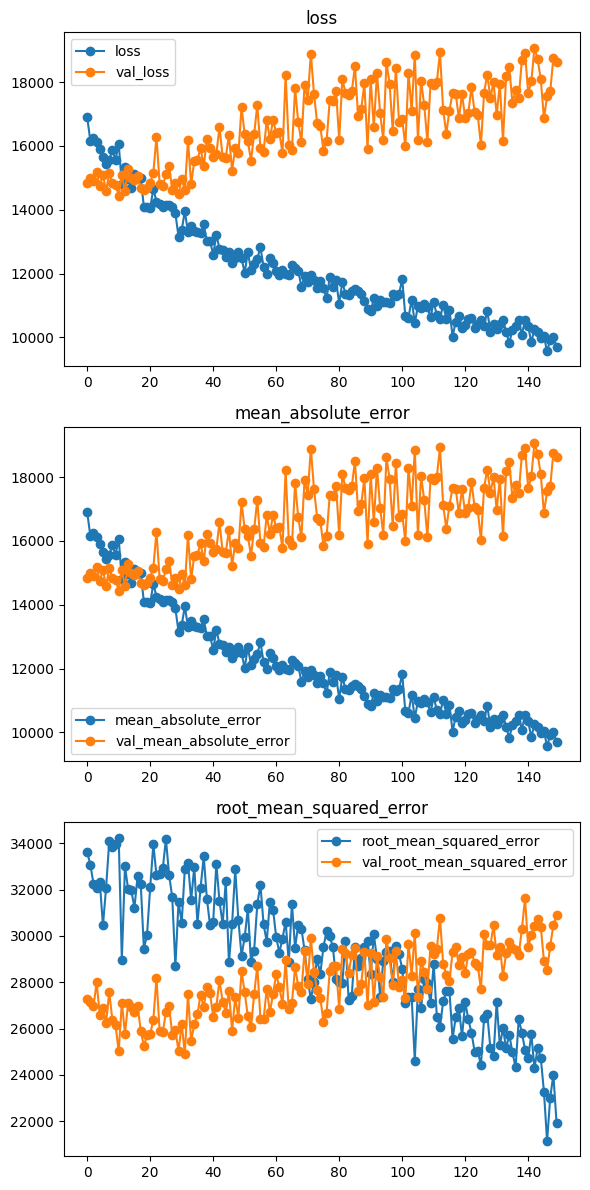

In [ ]:
plot_history(history);

In [ ]:
# evaluate on training set
y_pred = best_model.predict(X_train_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
final RMSE: 23391.965800248596
final MAE: 12267.060546875
final R2: 0.909084141254425


In [ ]:
# evaluate on testing set
y_pred = best_model.predict(X_test_processed)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
final RMSE: 21374.286607978287
final MAE: 15450.7646484375
final R2: 0.9272634983062744


- It is overfitting

# Try models using PCs

In [ ]:
pca= PCA(n_components=0.90)
X_train_pca = pca.fit_transform(X_train_processed)
X_val_pca = pca.transform(X_val_processed)
X_test_pca = pca.transform(X_test_processed)

In [ ]:
input_shape = X_train_pca.shape[1]
input_shape

36

In [ ]:
model_1 = Sequential()

In [ ]:
model_1.add(Dense(40, activation='relu', input_shape=(input_shape,)))
model_1.add(Dense(36, activation='relu'))
model_1.add(Dropout(0.2))
model_1.add(Dense(32, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(25, activation='relu'))
model_1.add(Dense(15, activation='relu'))
model_1.add(Dense(10, activation='relu'))
model_1.add(Dense(1, activation='linear'))

In [ ]:
model_1.compile(loss = 'mae', optimizer = 'adam',metrics=[metrics.MeanAbsoluteError(), metrics.RootMeanSquaredError()])

In [ ]:
history_1 = model_1.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val), epochs=100, batch_size=32, verbose=1)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 186534.1250 - mean_absolute_error: 186534.1250 - root_mean_squared_error: 203943.9844 - val_loss: 174311.6406 - val_mean_absolute_error: 174311.6406 - val_root_mean_squared_error: 194922.7500
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 186527.3594 - mean_absolute_error: 186527.3594 - root_mean_squared_error: 203937.7656 - val_loss: 174253.3125 - val_mean_absolute_error: 174253.3125 - val_root_mean_squared_error: 194869.8438
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 186350.9219 - mean_absolute_error: 186350.9219 - root_mean_squared_error: 203773.8125 - val_loss: 172979.5938 - val_mean_absolute_error: 172979.5938 - val_root_mean_squared_error: 193710.3750
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 183270.2969 - mean_absolute_error: 183270.2969 - root_mean_squared_error: 200917.7500 - val_loss: 156296.7500 - val_mean_absolute_error: 156296.7500 - val_root_mean_squared_error: 178762.

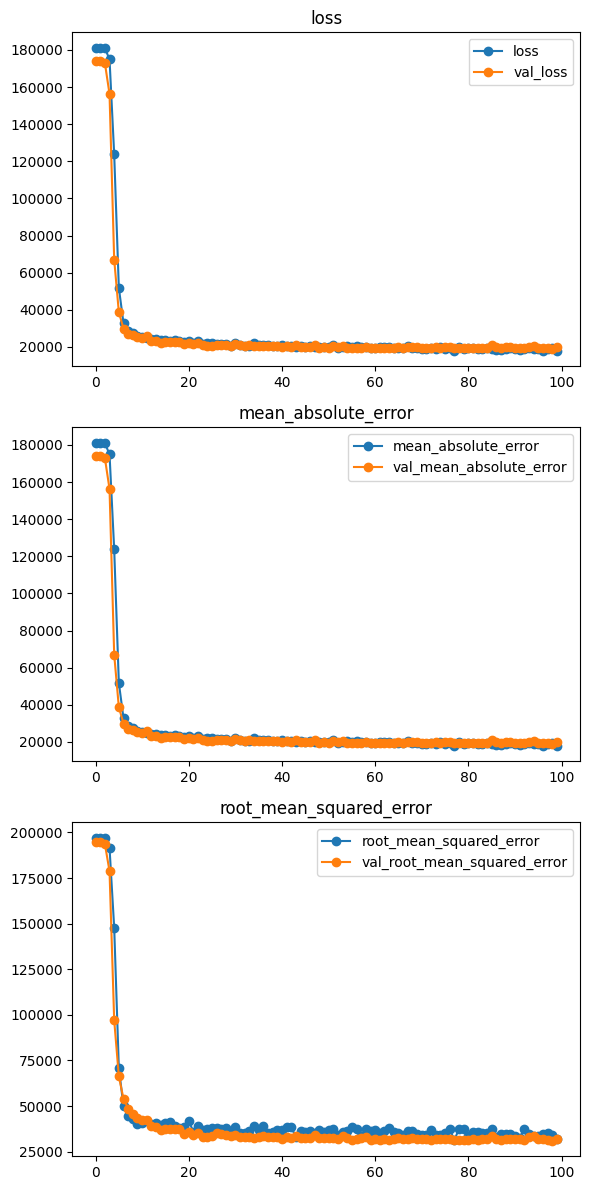

In [ ]:
plot_history(history_1);

In [ ]:
#evaluate on training set
y_pred = model_1.predict(X_train_pca)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_train, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_train, y_pred)}')
print(f'final R2: {r2_score(y_train, y_pred)}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
final RMSE: 30039.19253242337
final MAE: 13802.3798828125
final R2: 0.8500719666481018


In [ ]:
# evaluate on testing set
y_pred = model_1.predict(X_test_pca)
print(f'final RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
print(f'final MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'final R2: {r2_score(y_test, y_pred)}')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
final RMSE: 26209.505451267105
final MAE: 19148.5703125
final R2: 0.8906328082084656


- It`s overfitting

#Final result

- The first model in this notebook was the best model as the gap between training set loss and testing set loss was 6$ .